In [21]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


In [22]:
#Load clean data

df = pd.read_csv("../data/cleaned_transactions.csv")
df.shape


(6362620, 13)

In [23]:
#Filter: Focus on 'TRANSFER' & 'CASH_OUT'
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()
df.shape


(2770409, 13)

In [24]:
#Feature Engineering
df['isHighAmount'] = df['amount'] > df['amount'].quantile(0.99)
df['balanceChange'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24


In [25]:
#5. Standardize Features
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'balanceChange']
scaler = StandardScaler()
X = scaler.fit_transform(df[features])


In [26]:
#6. Isolation Forest (Unsupervised Anomaly Detection)

model = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
df['anomaly_score'] = model.fit_predict(X)
df['isAnomaly'] = (df['anomaly_score'] == -1).astype(int)


/var/folders/zw/q57nvchx4px_sjq5v4zf2nwc0000gn/T/ipykernel_48901/345437074.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='isAnomaly', data=df, palette='coolwarm')


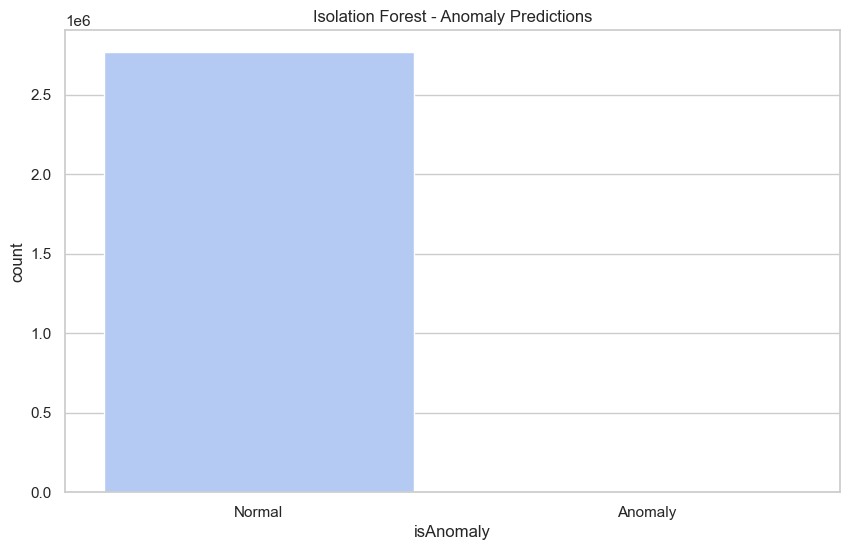

In [27]:
#7. Visualize Anomaly Score Distribution
sns.countplot(x='isAnomaly', data=df, palette='coolwarm')
plt.title("Isolation Forest - Anomaly Predictions")
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.show()


In [28]:
#8. Evaluate Against Actual Labels
print("Confusion Matrix:")
print(confusion_matrix(df['isFraud'], df['isAnomaly']))

print("\nClassification Report:")
print(classification_report(df['isFraud'], df['isAnomaly']))

Confusion Matrix:
[[2760787    1409]
 [   6946    1267]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2762196
           1       0.47      0.15      0.23      8213

    accuracy                           1.00   2770409
   macro avg       0.74      0.58      0.62   2770409
weighted avg       1.00      1.00      1.00   2770409



In [29]:
#9. Show Top Anomalous Transactions
df[df['isAnomaly'] == 1].sort_values(by='amount', ascending=False).head(10)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,isHighAmount,balanceChange,anomaly_score,isAnomaly
4157895,303,TRANSFER,37387628.10,C102829469,862621.88,0.0,C1997281537,37843025.59,7.523065e+07,0,0,15,12,True,862621.88,-1,1
4136960,303,TRANSFER,29802113.19,C1289440255,550210.01,0.0,C1496190878,48574467.89,1.542623e+08,0,0,15,12,True,550210.01,-1,1
4155239,303,TRANSFER,29642476.68,C1371587316,539407.79,0.0,C140277928,53476069.02,8.311855e+07,0,0,15,12,True,539407.79,-1,1
4098590,301,TRANSFER,11827804.14,C711214156,860642.26,0.0,C2003377069,13384116.82,2.521192e+07,0,0,13,12,True,860642.26,-1,1
4529310,326,TRANSFER,11093224.65,C1831789253,727449.73,0.0,C1501701470,17943243.79,2.903647e+07,0,0,14,13,True,727449.73,-1,1
4550880,327,TRANSFER,10893697.21,C1803111508,601660.70,0.0,C1033714356,14911019.34,2.580472e+07,0,0,15,13,True,601660.70,-1,1
4154934,303,TRANSFER,10876717.14,C1898217794,592861.99,0.0,C32884824,13086243.72,2.396296e+07,0,0,15,12,True,592861.99,-1,1
4554344,327,TRANSFER,10367319.82,C1835952163,552322.68,0.0,C1784564645,22702042.68,3.306936e+07,0,0,15,13,True,552322.68,-1,1
4551925,327,TRANSFER,10079894.57,C1037961127,553104.01,0.0,C1727128330,29134698.61,3.921459e+07,0,0,15,13,True,553104.01,-1,1
4589293,328,TRANSFER,10000000.00,C873866898,625805.00,0.0,C1071107520,42336.33,1.426981e+07,0,0,16,13,True,625805.00,-1,1


In [30]:
# Group by sender and compute average time gap
df['prev_step'] = df.groupby('nameOrig')['step'].shift(1)
df['step_gap'] = df['step'] - df['prev_step']
df['step_gap'].fillna(0, inplace=True)


/var/folders/zw/q57nvchx4px_sjq5v4zf2nwc0000gn/T/ipykernel_48901/487523880.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['step_gap'].fillna(0, inplace=True)


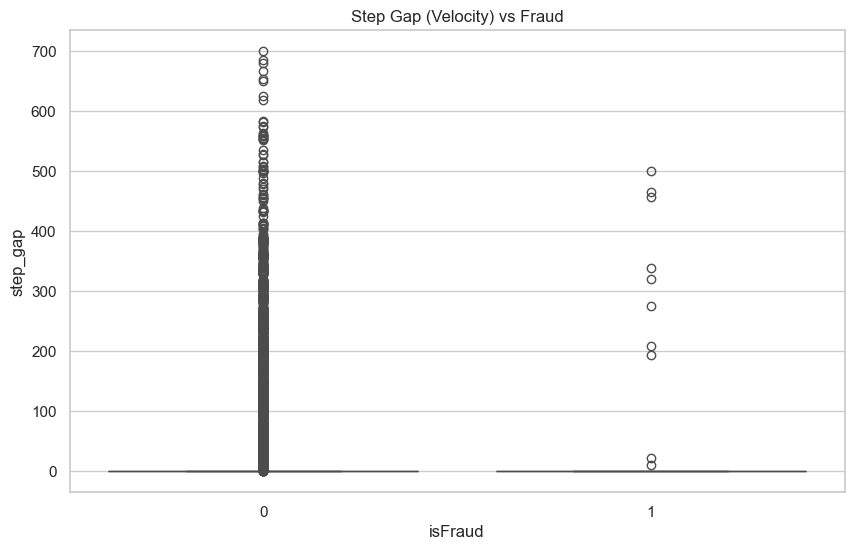

In [31]:
#11. Step Gap vs Fraud 
sns.boxplot(x='isFraud', y='step_gap', data=df)
plt.title("Step Gap (Velocity) vs Fraud")
plt.show()


/var/folders/zw/q57nvchx4px_sjq5v4zf2nwc0000gn/T/ipykernel_48901/2255462060.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/mahalakshmirajabattula/Library/Mobile Documents/com~apple~CloudDocs/transaction_forensic_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


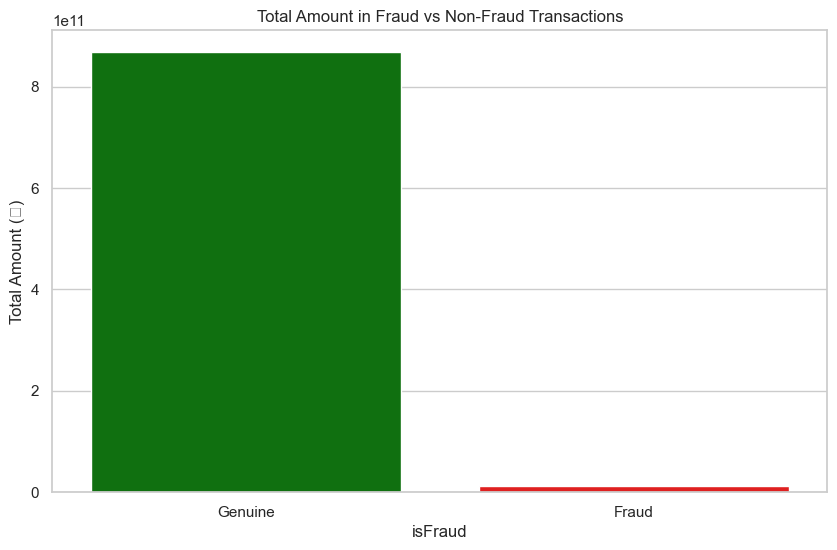

In [32]:
#Visualize Fraud Amount vs Non-Fraud
sns.barplot(
    data=df.groupby("isFraud")["amount"].sum().reset_index(),
    x="isFraud",
    y="amount",
    palette=["green", "red"]
)
plt.xticks([0, 1], ["Genuine", "Fraud"])
plt.title("Total Amount in Fraud vs Non-Fraud Transactions")
plt.ylabel("Total Amount (₹)")
plt.show()


/Users/mahalakshmirajabattula/Library/Mobile Documents/com~apple~CloudDocs/transaction_forensic_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


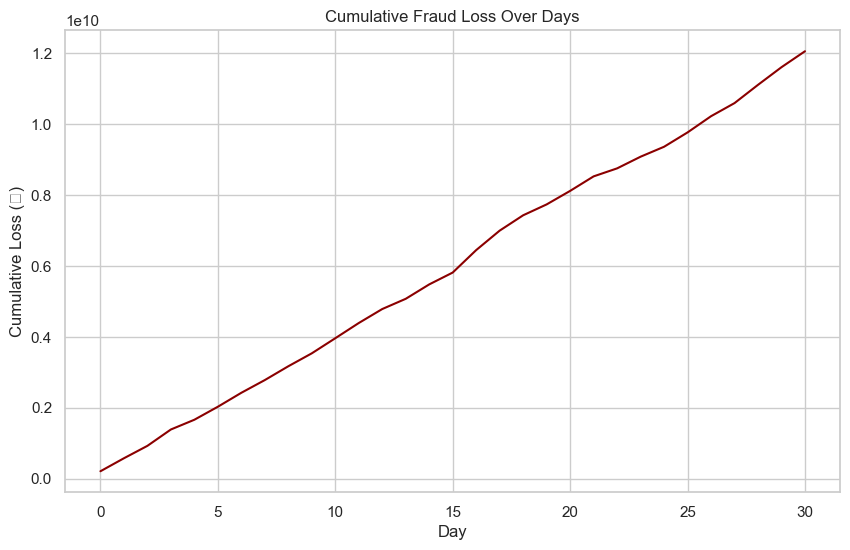

In [33]:
#Create a Cumulative Fraud Over Time Plot
df['fraud_amount'] = df['amount'] * df['isFraud']
daily_loss = df.groupby(df['step'] // 24)['fraud_amount'].sum().cumsum()

plt.plot(daily_loss, color='darkred')
plt.title("Cumulative Fraud Loss Over Days")
plt.xlabel("Day")
plt.ylabel("Cumulative Loss (₹)")
plt.grid(True)
plt.show()
